In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install neuroCombat

  Preparing metadata (setup.py) ... done
  Created wheel for neuroCombat: filename=neuroCombat-0.2.12-py3-none-any.whl size=6353 sha256=8170beaa1be86947a8af543d0b3e78a2e4d2161edf3b2a3f47dba4c9b3f9133d
  Stored in directory: /root/.cache/pip/wheels/be/6a/95/9d827c0f3cc23854b5fbd00fbc8a052d492538dc16bd20f7a2
Successfully built neuroCombat


In [3]:
import gzip
# import GEOparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from neuroCombat import neuroCombat  # pip install neuroCombat
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

exp_paths = {
    "RABC2": "/content/drive/MyDrive/genesExpression/RABC2_Level3.txt",
    "RABC3": "/content/drive/MyDrive/genesExpression/RABC3_Level3.txt",
    # "RABC4": "/content/drive/MyDrive/genesExpression/RABC4_Level3.txt",
    "RABC7": "/content/drive/MyDrive/genesExpression/RABC7_Level3.txt", #whole blood
    "RABC12": "/content/drive/MyDrive/genesExpression/RABC12_Level3.txt", #whole blood
    "RABC15": "/content/drive/MyDrive/genesExpression/RABC15_Level3.txt", #whole blood
    # "RABC18": "/content/drive/MyDrive/genesExpression/RABC18_Level3.txt", #Monocyte_CD14dim.CD16+
    # "RABC39": "/content/drive/MyDrive/genesExpression/RABC39_Level3.txt",

}

pheno_paths = {
    "RABC2": "/content/drive/MyDrive/genesExpression/phenotypes/RABC2_PhenotypeFile.csv",
    "RABC3": "/content/drive/MyDrive/genesExpression/phenotypes/RABC3_PhenotypeFile.csv",
    # "RABC4": "/content/drive/MyDrive/genesExpression/phenotypes/RABC4_PhenotypeFile.csv",
    "RABC7": "/content/drive/MyDrive/genesExpression/phenotypes/RABC7_PhenotypeFile.csv",
    "RABC12": "/content/drive/MyDrive/genesExpression/phenotypes/RABC12_PhenotypeFile.csv",
    "RABC15": "/content/drive/MyDrive/genesExpression/phenotypes/RABC15_PhenotypeFile.csv",
    # "RABC18": "/content/drive/MyDrive/genesExpression/phenotypes/RABC18_PhenotypeFile.csv",
    # "RABC39": "/content/drive/MyDrive/genesExpression/phenotypes/RABC39_PhenotypeFile.csv",
}


# Load Datasets

In [5]:
def load_rabc_dataset(expr_path, pheno_path, name):
    print(f"Loading {name} ...")

    # ---------- Load expression ----------
    expr = pd.read_csv(expr_path, sep="\t", comment="#", low_memory=False)
    expr = expr.rename(columns={expr.columns[0]: "GeneSymbol"})
    expr = expr.dropna(subset=["GeneSymbol"])
    expr = expr.set_index("GeneSymbol")

    # ---------- Load phenotype ----------
    pheno = pd.read_csv(pheno_path)

    # pehontype columns: sample, status
    # status: 1 = RA, 0 = Healthy
    pheno["Label"] = pheno["status"].map({1: "RA", 0: "Healthy"})

    # ---------- Match samples ----------
    # Expression columns(GSE...) must match phenotype sample IDs(GSE...)
    common_samples = expr.columns.intersection(pheno["sample"])

    if len(common_samples) == 0:
        raise ValueError(f"No matching samples found for {name}")

    expr = expr[common_samples]
    pheno = pheno.set_index("sample").loc[common_samples]

    # ---------- Transpose ----------
    df = expr.T
    df["Label"] = pheno["Label"].values
    df["Batch"] = name
    # print(df)
    print(f"✅ {name}: {df.shape[0]} samples × {df.shape[1]-2} genes")

    numeric_cols = df.drop(columns=['Label', 'Batch'])
    imputer = SimpleImputer(strategy='median')
    df[numeric_cols.columns] = imputer.fit_transform(numeric_cols)
    return df


In [6]:
!pip install mygene

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.2 MB/s eta 0:00:00


In [11]:
# --- 1. Sub-function: Metadata Extraction ---
def get_metadata_and_lines(file_path):
    gsm_ids, sample_metadata_map = [], {}
    data_start_line, platform_start_line = 0, 0
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if line.startswith('!Sample_geo_accession'):
                gsm_ids = [val.strip().replace('"', '') for val in line.split('\t')[1:]]
                for idx in range(len(gsm_ids)): sample_metadata_map[idx] = []
            elif line.startswith('!Sample_title') or line.startswith('!Sample_characteristics_ch1'):
                parts = [val.strip().replace('"', '').lower() for val in line.split('\t')[1:]]
                for idx, text in enumerate(parts):
                    if idx in sample_metadata_map: sample_metadata_map[idx].append(text)
            elif line.startswith('#ID = '): platform_start_line = i
            elif line.startswith('!series_matrix_table_begin'):
                data_start_line = i + 1
                break
    return gsm_ids, sample_metadata_map, data_start_line, platform_start_line

# --- 2. Sub-function: Labeling ---
def assign_labels(gsm_ids, sample_metadata_map):
    final_labels = []
    for idx in range(len(gsm_ids)):
        text = " ".join(sample_metadata_map.get(idx, [])).lower()
        is_ra = any(x in text for x in ['disease state: ra', 'diagnosis: ra', 'rheumatoid', ': ra', 'disease: rheumatoid'])
        is_healthy = any(x in text for x in ['normal', 'healthy', 'control'])
        if is_ra and not is_healthy: final_labels.append('RA')
        elif is_healthy and not is_ra: final_labels.append('Healthy')
        else: final_labels.append('Unknown')
    return final_labels

# --- 3. Sub-function: Local GPL Mapping --

def map_probes_to_local_gpl(expr_df, mapping_file):
    print(f"Reading GPL Mapping: {mapping_file.split('/')[-1]}")

    try:
        # Load GPL, skipping comment lines
        gpl = pd.read_csv(mapping_file, sep='\t', comment='#', low_memory=False)
    except Exception as e:
        print(f" Error reading GPL: {e}")
        return expr_df

    # Clean column names
    gpl.columns = [c.replace('"', '').strip() for c in gpl.columns]
    id_col = gpl.columns[0]

    # Find the Symbol column
    symbol_cols = [c for c in gpl.columns if 'symbol' in c.lower() and 'id' not in c.lower()]
    if not symbol_cols:
        print(f" Could not find Symbol column. Available: {list(gpl.columns[:5])}")
        return expr_df

    target_symbol_col = symbol_cols[0]
    print(f"Found mapping column: '{target_symbol_col}'")

    # Clean the Symbol column (handling 'DDR1 /// MIR4640')
    def clean_symbol(val):
        val = str(val).replace('"', '').strip()
        if '///' in val:
            val = val.split('///')[0].strip()
        # Ensure we don't treat numeric IDs or empty strings as symbols
        if val.isdigit() or val in ['nan', '---', 'None', 'null', '']:
            return np.nan
        return val

    gpl[target_symbol_col] = gpl[target_symbol_col].apply(clean_symbol)

    # Create mapping dictionary and remove NaNs
    mapping_dict = gpl.set_index(id_col)[target_symbol_col].dropna().to_dict()

    # Apply mapping to the index
    # If the probe is NOT in the dictionary, it stays as the probe ID
    expr_df.index = expr_df.index.map(lambda x: mapping_dict.get(str(x), x))

    # CRUCIAL STEP: Remove rows that are still Probe IDs
    # This ensures "1007_s_at" is either "A1BG" or DELETED
    def is_probe(idx):
        idx_str = str(idx)
        # Check for common probe patterns or if it's still a number
        return ('_at' in idx_str or
                idx_str.startswith('AGhs') or
                idx_str.startswith('Affx') or
                idx_str == 'nan')

    # Keep only rows where is_probe is FALSE
    expr_df = expr_df[~expr_df.index.map(is_probe)]

    mapped_count = len(expr_df.index.unique())
    print(f"✅ Successfully mapped to {mapped_count} unique Gene Symbols.")

    # Collapse duplicates by mean and return
    return expr_df.groupby(expr_df.index).mean()



def normalize_and_log(df, batch_label):
    # Separate numeric data from metadata
    metadata_cols = ['Label', 'Batch']
    numeric_df = df.drop(columns=metadata_cols)

    # 1. Check for Log Transformation
    # If the max value is very high, it's likely raw intensity
    max_val = numeric_df.max().max()
    if max_val > 20:
        print(f"[{batch_label}] Max value {max_val:.2f} detected. Applying log2 transformation...")
        # Add a small constant (1) to avoid log(0)
        numeric_df = np.log2(numeric_df + 1)
    else:
        print(f"[{batch_label}] Data appears to be already log-transformed (Max: {max_val:.2f}).")

    # 2. Z-Score Normalization (Standardization)
    # This centers each gene to Mean=0 and STD=1
    # This is crucial for merging different platforms!
    print(f"[{batch_label}] Applying Z-score normalization...")
    numeric_df = (numeric_df - numeric_df.mean()) / numeric_df.std()

    # Re-attach metadata
    normalized_df = pd.concat([numeric_df, df[metadata_cols]], axis=1)
    return normalized_df

def remove_outliers_iqr(df, n_components=2, factor=1.5):
    """
    Identifies and removes outliers using the IQR method on PCA coordinates.
    factor: The multiplier for IQR (1.5 is standard, 3.0 is for 'extreme' outliers).
    """
    print(f"\n--- Identifying Outliers via IQR (Factor: {factor}) ---")

    # 1. Prepare numeric data
    metadata_cols = ['Label', 'Batch']
    numeric_df = df.drop(columns=metadata_cols)

    # 2. Project data into PCA space
    pca = PCA(n_components=n_components)
    pca_results = pca.fit_transform(numeric_df)
    pca_cols = [f'PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(pca_results, columns=pca_cols, index=df.index)

    # 3. Apply IQR filtering on each Principal Component
    mask = pd.Series(True, index=df.index)

    for col in pca_cols:
        Q1 = pca_df[col].quantile(0.25)
        Q3 = pca_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (factor * IQR)
        upper_bound = Q3 + (factor * IQR)

        # Update mask: keep only samples within bounds for ALL PCs
        column_mask = (pca_df[col] >= lower_bound) & (pca_df[col] <= upper_bound)
        mask = mask & column_mask

    clean_df = df[mask]
    outlier_count = len(df) - len(clean_df)

    print(f"Detected and removed {outlier_count} outliers using IQR.")
    print(f"Samples remaining: {clean_df.shape[0]}")

    return clean_df

# --- 4. Main Wrapper Function ---
def process_geo_dataset(file_path, batch_label, gpl_path):
    print(f"\n{'='*20}\nProcessing: {batch_label}\n{'='*20}")

    gsm_ids, sample_metadata_map, data_line, _ = get_metadata_and_lines(file_path)
    final_labels = assign_labels(gsm_ids, sample_metadata_map)

    print(f"Labels Found: RA={final_labels.count('RA')}, Healthy={final_labels.count('Healthy')}")

    # Load Expression Matrix
    expr_df = pd.read_csv(file_path, sep='\t', skiprows=data_line, comment='!', index_col=0)

    # Apply SimpleImputer to handle missing values mathematically
    imputer = SimpleImputer(strategy='median')
    # We transpose because imputer works on columns (samples), but we want to impute genes
    expr_df_imputed = imputer.fit_transform(expr_df.T).T #arg3ha b3d transpose zy ma kanet
    expr_df = pd.DataFrame(expr_df_imputed, index=expr_df.index, columns=expr_df.columns)

    expr_df.columns = [c.replace('"', '').strip() for c in expr_df.columns]

    print(f"\n[BEFORE MAPPING] Rows: {expr_df.shape[0]}")
    print(expr_df.iloc[:3, :3]) # Print first 3 rows/cols

    # Map Probes
    expr_df = map_probes_to_local_gpl(expr_df, gpl_path)

    print(f"\n[AFTER MAPPING] Rows: {expr_df.shape[0]}")
    print(expr_df.iloc[:5, :3])
    # Format Output
    label_map = dict(zip(gsm_ids, final_labels))
    valid_gsm = [gsm for gsm in expr_df.columns if gsm in label_map and label_map[gsm] != 'Unknown']

    df_final = expr_df[valid_gsm].T.astype(np.float32)
    df_final['Label'] = [label_map[gsm] for gsm in df_final.index]
    df_final['Batch'] = batch_label

    print(f"✅ Success: {batch_label} ready.")
    return df_final

datasets_geo = {
    "GSE93272": {
        "matrix": "/content/drive/MyDrive/genesExpFolder/GSE93272_series_matrix.txt",
        "gpl": "/content/drive/MyDrive/genesExpFolder/mapping/GPL570.txt"
    },
    "GSE110169": {
        "matrix": "/content/drive/MyDrive/genesExpFolder/GSE110169_series_matrix.txt",
        "gpl": "/content/drive/MyDrive/genesExpFolder/mapping/GPL13667.txt"
    }
    # ,
    # "GSE17755": {
    #     "matrix": "/content/drive/MyDrive/genesExpFolder/GSE17755_series_matrix.txt",
    #     "gpl": "/content/drive/MyDrive/genesExpFolder/mapping/GPL1291.txt"
    # }
}

all_dfs = []

# --- Part A: Process GEO Datasets (Mapping needed) ---
for name, info in datasets_geo.items():
    try:
        df = process_geo_dataset(info["matrix"], name, info["gpl"])
        print(f"Datasett: {name}{df}\n")

        if not df.empty:
            df_norm = normalize_and_log(df, name)
            all_dfs.append(df_norm)
    except Exception as e:
        print(f" Failed {name}: {e}")

# --- Part B: Process RABC Datasets (Already mapped) ---
for name in exp_paths:
    try:
        # 1. Load using your RABC function
        df_rabc = load_rabc_dataset(
            expr_path=exp_paths[name],
            pheno_path=pheno_paths[name],
            name=name
        )

        # 2. Normalize and Log (Crucial so RABC scales match GEO scales)
        if not df_rabc.empty:
            df_norm = normalize_and_log(df_rabc, name)
            all_dfs.append(df_norm)
    except Exception as e:
        print(f" Failed RABC {name}: {e}")

# Final Concatenation
if all_dfs:
    master_df = pd.concat(all_dfs, axis=0, join='inner')
    non_gene_cols = master_df.columns.str.contains('_at|AGhs|Affx|^[0-9]+$', case=False, na=False)
    cols_to_keep = (~non_gene_cols) | (master_df.columns.isin(['Label', 'Batch']))
    master_df = master_df.loc[:, cols_to_keep]

    # 3. REMOVE OUTLIERS via IQR
    # Using factor=1.5 will be aggressive; use factor=3.0 to only hit the far-left group.
    master_df_after = remove_outliers_iqr(master_df, n_components=2, factor=3.0)

    print("\n" + "#"*40)
    print(f"INTEGRATION COMPLETE")
    print(f"Total Samples: {master_df.shape[0]}")
    print(f"Final Common Genes: {master_df.shape[1] - 2}")
    print("#"*40)


Processing: GSE93272
Labels Found: RA=232, Healthy=43

[BEFORE MAPPING] Rows: 54613
           GSM2449608  GSM2449609  GSM2449610
ID_REF                                       
1007_s_at    7.612408    7.567729    7.270872
1053_at      6.414243    6.244399    6.452396
117_at       9.191961    9.110493    9.534272
Reading GPL Mapping: GPL570.txt
Found mapping column: 'Gene Symbol'
✅ Successfully mapped to 22880 unique Gene Symbols.

[AFTER MAPPING] Rows: 22880
          GSM2449608  GSM2449609  GSM2449610
ID_REF                                      
A1BG        5.711134    5.391102    5.731230
A1BG-AS1    5.348312    4.932976    5.530504
A1CF        4.078800    4.121829    3.992224
A2M         4.924560    5.344483    4.868409
A2M-AS1     8.092333    9.080001    8.774505
✅ Success: GSE93272 ready.
Datasett: GSE93272ID_REF          A1BG  A1BG-AS1      A1CF       A2M   A2M-AS1     A2ML1  \
GSM2449608  5.711134  5.348312  4.078800  4.924560  8.092334  3.863759   
GSM2449609  5.391102  4.9329

In [13]:
master_df=master_df_after
healthy=master_df[master_df['Label']=='Healthy']
ra=master_df[master_df['Label']=='RA']
empty=master_df.isna().sum()

In [14]:

print(f"Datasett:{master_df}\n")


Datasett:                A1BG      A1CF       A2M     A2ML1    A4GALT     A4GNT  \
GSM2449608 -0.112162  0.165233  1.416933 -0.079265 -0.234044  0.564811   
GSM2449609 -1.507696  0.455092  3.814519  2.184362 -0.015770  0.964654   
GSM2449610 -0.024532 -0.417974  1.096338  1.058701 -0.548015 -1.088476   
GSM2449611 -2.242073  0.939581  1.334835 -0.367725  0.844550  1.500647   
GSM2449612 -1.672083 -1.361220 -0.429249  0.719501  0.389794  0.188608   
...              ...       ...       ...       ...       ...       ...   
GSM3449674  1.380913  1.020981 -0.496942  1.608542  0.224708  0.978580   
GSM3449675  0.112044 -0.276469 -1.680157 -0.582877 -0.314280 -0.106763   
GSM3449676  0.063118 -0.214029 -1.659649 -0.493540 -0.369005 -0.968249   
GSM3449677 -1.401229 -0.794176  0.084455 -1.085981 -0.233393 -0.124871   
GSM3449678 -0.386727 -0.768891  0.106454 -0.405353 -0.030051 -0.247604   

                AAAS      AACS     AADAC   AADACL2  ...      ZXDA      ZXDB  \
GSM2449608  0.941837 -0

In [15]:
# Clean the final dataframe
master_df = master_df.dropna(subset=['Label'])

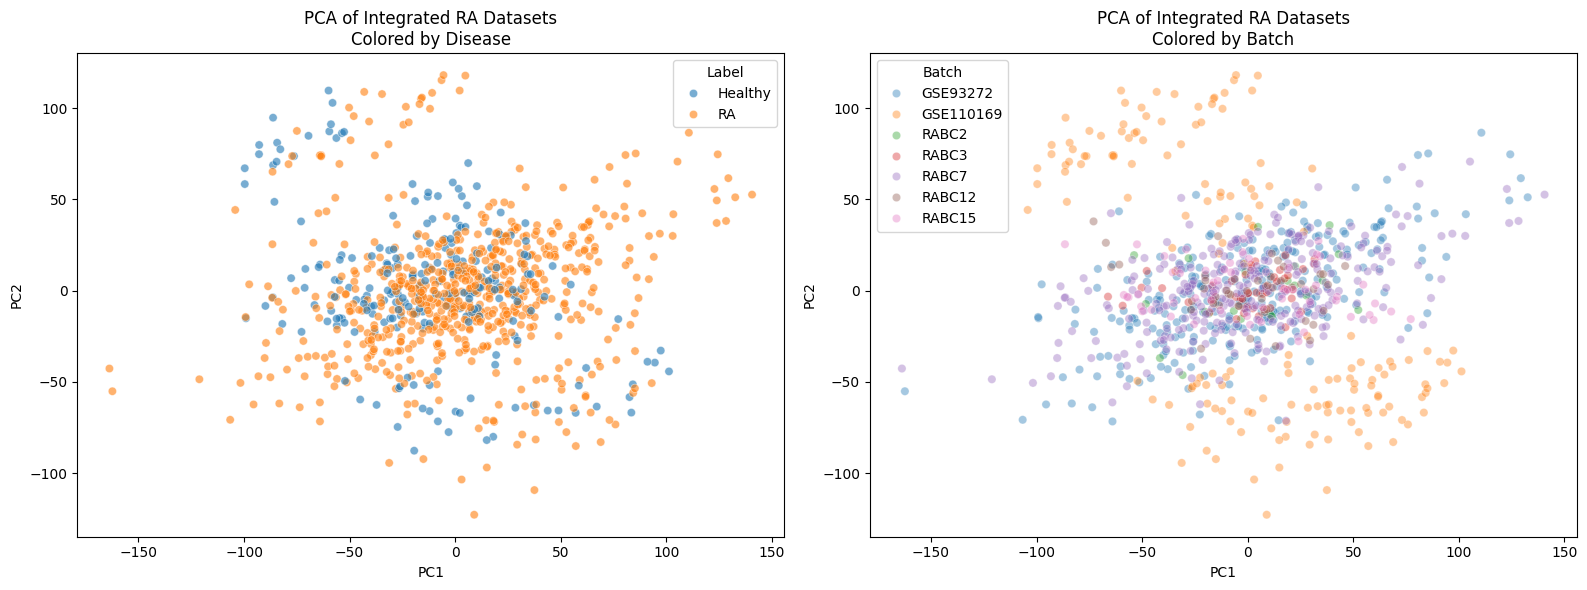

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

def plot_pca(df, title="PCA of Integrated RA Datasets"):
    # 1. Prepare Data (Drop Metadata)
    features = df.drop(columns=['Label', 'Batch'])
    labels = df['Label']
    batches = df['Batch']

    # 2. Run PCA
    pca = PCA(n_components=2)
    components = pca.fit_transform(features)

    # 3. Create Plotting DataFrame
    pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
    pca_df['Label'] = labels.values
    pca_df['Batch'] = batches.values

    # 4. Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot A: Colored by Disease (Biological Signal)
    sns.scatterplot(ax=axes[0], data=pca_df, x='PC1', y='PC2', hue='Label', alpha=0.6)
    axes[0].set_title(f"{title}\nColored by Disease")

    # Plot B: Colored by Batch (Technical Signal)
    sns.scatterplot(ax=axes[1], data=pca_df, x='PC1', y='PC2', hue='Batch', alpha=0.4)
    axes[1].set_title(f"{title}\nColored by Batch")

    plt.tight_layout()
    plt.show()

# Run the function
plot_pca(master_df)

# ComBat Batch Correction

Running ComBat... this may take a moment for 16,000 genes.
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


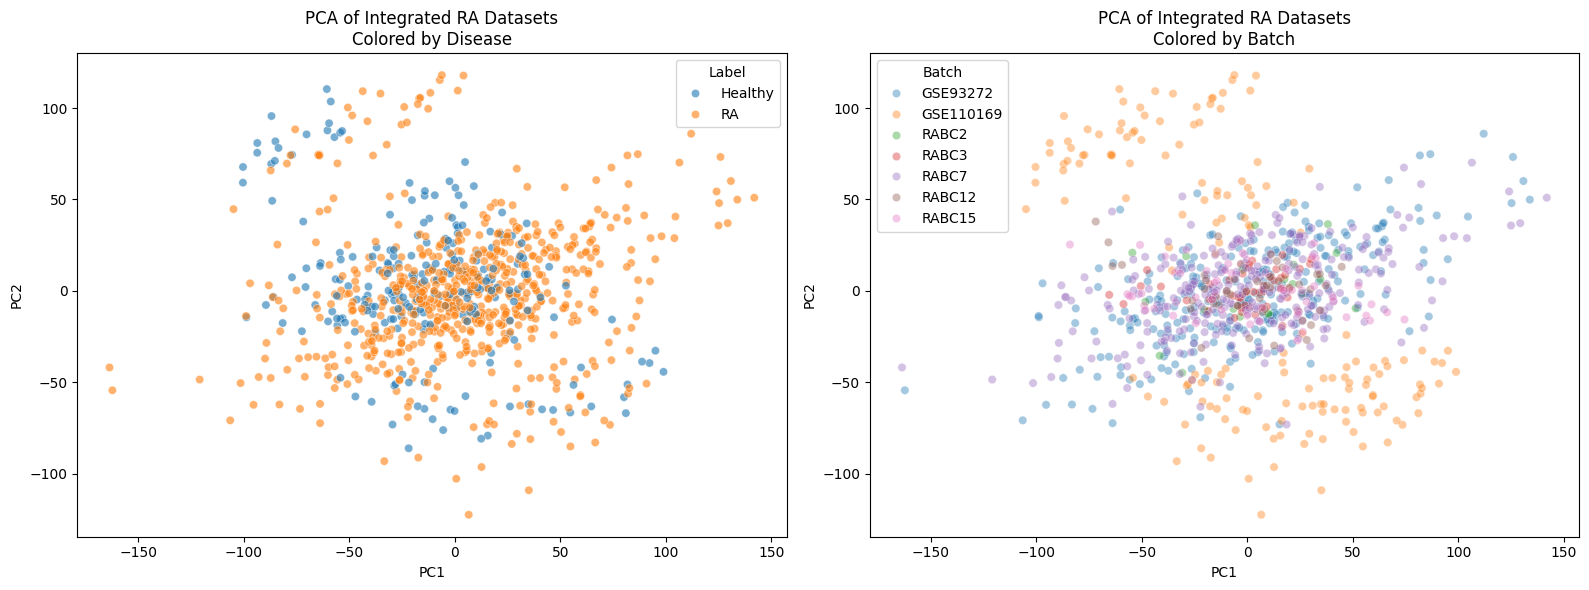

In [17]:
def apply_combat_correction(df):
    # 1. Separate Metadata and Gene Data
    # Drop samples with NaN labels first to avoid errors
    df_clean = df.dropna(subset=['Label']).copy()

    metadata = df_clean[['Label', 'Batch']]
    # neuroCombat expects genes as rows and samples as columns
    data_to_correct = df_clean.drop(columns=['Label', 'Batch']).values.T

    # 2. Define Batch and Covariates
    # 'Batch' is the technical noise; 'Label' is the biological signal we want to PROTECT
    batch_list = metadata['Batch'].tolist()
    categorical_cols = ['Label']

    print("Running ComBat... this may take a moment for 16,000 genes.")

    # 3. Execute ComBat
    # This adjusts the data so the Mean and Variance of each batch align
    data_corrected = neuroCombat(
        dat=data_to_correct,
        covars=metadata,
        batch_col='Batch',
        categorical_cols=categorical_cols
    )["data"]

    # 4. Transpose back and Reconstruct DataFrame
    df_corrected = pd.DataFrame(
        data_corrected.T,
        index=df_clean.index,
        columns=df_clean.drop(columns=['Label', 'Batch']).columns
    )

    # Re-attach Label and Batch
    df_final = pd.concat([df_corrected, metadata], axis=1)
    return df_final

# Apply the correction
master_df_corrected = apply_combat_correction(master_df)

plot_pca(master_df_corrected)

# Statistical Feature Selection

In [19]:
# Identify the most informative genes
def select_top_genes(df, top_n=2000):
    # Separate numeric data
    numeric_df = df.drop(columns=['Label', 'Batch'])

    # Calculate variance for each gene
    gene_variances = numeric_df.var().sort_values(ascending=False)

    # Select top N gene names
    top_genes = gene_variances.head(top_n).index.tolist()

    print(f"Selected top {top_n} genes based on variance.")

    # Keep metadata columns
    return df[top_genes + ['Label', 'Batch']]

# Apply to corrected data
master_df_filtered = select_top_genes(master_df_corrected, top_n=2000)

Selected top 2000 genes based on variance.


# Encode labels and train/test split

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Encode Labels (Healthy = 0, RA = 1)
le = LabelEncoder()
y = le.fit_transform(master_df_filtered['Label'])
X = master_df_filtered.drop(columns=['Label', 'Batch'])

# 2. Stratified Split
# 'stratify=y' ensures both Train and Test have the same % of RA patients
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# ML Models

## Random Forest

Best Parameters Found: {'class_weight': None, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 20, 'n_estimators': 200, 'random_state': 42}

==================== TEST SET EVALUATION ====================
              precision    recall  f1-score   support

     Healthy       0.78      0.68      0.73        47
          RA       0.89      0.93      0.91       129

    accuracy                           0.86       176
   macro avg       0.83      0.81      0.82       176
weighted avg       0.86      0.86      0.86       176



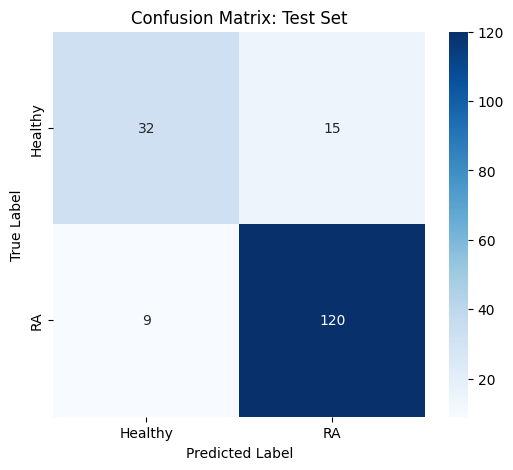

In [23]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

def train_rf_model(X_train, y_train):
    """Trains the model using SMOTE and GridSearch."""
    # Handle Class Imbalance
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Define the parameter grid
    param_grid = {
        'n_estimators': [200],
        'max_depth': [5, 6, 8],
        'min_samples_leaf': [15, 20, 30],
        'min_samples_split': [20, 40],
        'max_features': ['sqrt', 'log2'],
        'class_weight': [None],
        'random_state': [42]
    }

    # Initialize and Fit Grid Search
    rf = RandomForestClassifier()
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1
    )
    grid_search.fit(X_train_res, y_train_res)

    print(f"Best Parameters Found: {grid_search.best_params_}")
    return grid_search.best_estimator_

def display_test_results(model, X_test, y_test, target_names):
    """Displays only the Test Set classification report and confusion matrix."""
    preds = model.predict(X_test)

    # 1. Print Report
    print(f"\n{'='*20} TEST SET EVALUATION {'='*20}")
    print(classification_report(y_test, preds, target_names=target_names))

    # 2. Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix: Test Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# --- Execution ---

# 1. Train the model
rf_model = train_rf_model(X_train, y_train)

# 2. Show Testing results ONLY
display_test_results(rf_model, X_test, y_test, le.classes_)

In [24]:
#output predictions as probabilities
def get_probability_predictions(model, X, original_df_index):
    """
    Returns a dataframe showing the exact probability
    of having RA for each sample.
    """
    # predict_proba returns [prob_healthy, prob_ra]
    probabilities = model.predict_proba(X)

    prob_df = pd.DataFrame({
        'Sample_ID': original_df_index,
        'RA_Probability': probabilities[:, 1],  # Index 1 is usually 'RA'
        'Healthy_Probability': probabilities[:, 0],
        'Final_Diagnosis': model.predict(X)     # Shows the 0 or 1 label
    })

    prob_df['Final_Diagnosis'] = prob_df['Final_Diagnosis'].map({0: 'Healthy', 1: 'RA'})
    # Sort by highest risk
    return prob_df.sort_values(by='RA_Probability', ascending=False)

# Get probabilities for your Test Set
ra_probabilities = get_probability_predictions(rf_model, X_test, X_test.index)

print("\n" + "="*20 + " RA RISK PROBABILITIES (Top 10) " + "="*20)
print(ra_probabilities.head(10))


==================== RA RISK PROBABILITIES (Top 10) ====================
      Sample_ID  RA_Probability  Healthy_Probability Final_Diagnosis
132  GSM2449883        0.912505             0.087495              RA
8    GSM2449772        0.904578             0.095422              RA
16   GSM2449689        0.883479             0.116521              RA
35   GSM2449845        0.857817             0.142183              RA
26   GSM2449690        0.856089             0.143911              RA
130  GSM2449800        0.850479             0.149521              RA
33   GSM2449779        0.845297             0.154703              RA
76   GSM2449798        0.844101             0.155899              RA
83   GSM2449817        0.840861             0.159139              RA
142  GSM2449750        0.836919             0.163081              RA



> RF visualization



/tmp/ipython-input-1570249715.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Gene', data=feature_importance_df, palette='viridis')


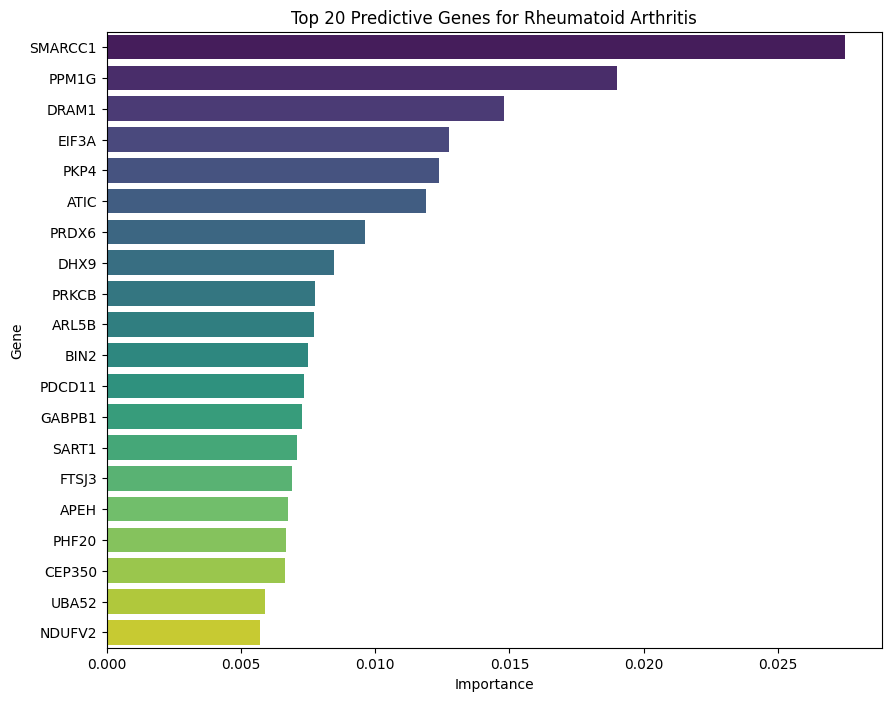

Top 5 Biomarker Candidates identified by the model:
['SMARCC1', 'PPM1G', 'DRAM1', 'EIF3A', 'PKP4']


In [25]:
# Extract and plot the top 20 most important genes
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Gene': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Gene', data=feature_importance_df, palette='viridis')
plt.title('Top 20 Predictive Genes for Rheumatoid Arthritis')
plt.show()

print("Top 5 Biomarker Candidates identified by the model:")
print(feature_importance_df['Gene'].head(5).tolist())

In [26]:

from scipy.stats import ttest_ind

def calculate_differential_expression(df):
    ra_group = df[df['Label'] == 'RA'].drop(columns=['Label', 'Batch'])
    healthy_group = df[df['Label'] == 'Healthy'].drop(columns=['Label', 'Batch'])

    results = []
    for gene in ra_group.columns:
        # Calculate Log2 Fold Change
        # Since data is already log-scaled or Z-scored, we subtract means
        log2fc = ra_group[gene].mean() - healthy_group[gene].mean()

        # Calculate P-value
        t_stat, p_val = ttest_ind(ra_group[gene], healthy_group[gene], equal_var=False)

        results.append({'Gene': gene, 'log2FC': log2fc, 'p_value': p_val})

    de_df = pd.DataFrame(results)
    de_df['-log10_p'] = -np.log10(de_df['p_value'])
    return de_df

# Calculate for your top genes
de_results = calculate_differential_expression(master_df_filtered)

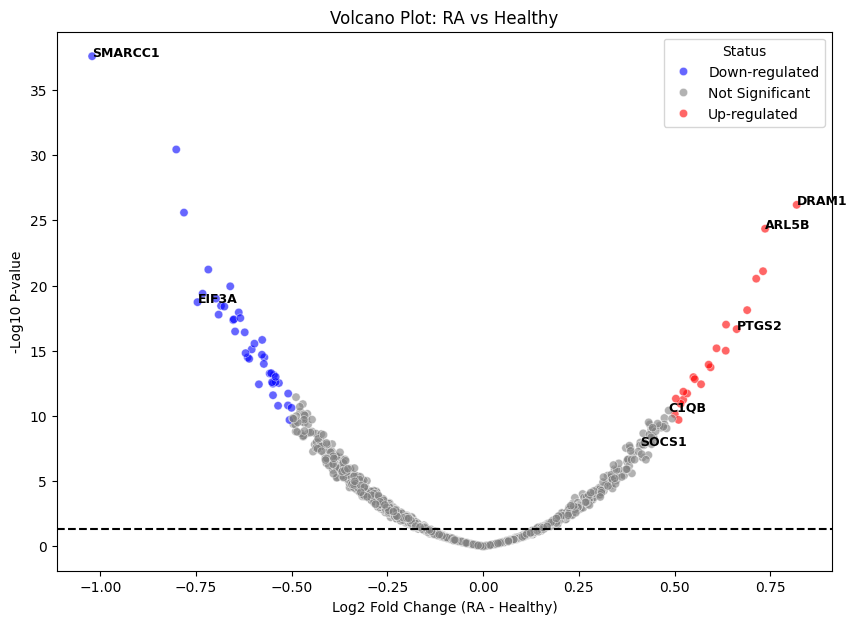

In [27]:
def plot_volcano(de_df, title="Volcano Plot: RA vs Healthy"):
    plt.figure(figsize=(10, 7))

    # Define significance thresholds
    p_thresh = 0.05
    fc_thresh = 0.5 # Change this based on your data's scale

    # Color coding
    de_df['Status'] = 'Not Significant'
    de_df.loc[(de_df['p_value'] < p_thresh) & (de_df['log2FC'] > fc_thresh), 'Status'] = 'Up-regulated'
    de_df.loc[(de_df['p_value'] < p_thresh) & (de_df['log2FC'] < -fc_thresh), 'Status'] = 'Down-regulated'

    sns.scatterplot(data=de_df, x='log2FC', y='-log10_p', hue='Status',
                    palette={'Not Significant': 'grey', 'Up-regulated': 'red', 'Down-regulated': 'blue'},
                    alpha=0.6)

    # Annotate top genes from your Random Forest list
    top_rf_genes = ['SMARCC1', 'DRAM1', 'ARL5B', 'EIF3A', 'PTGS2', 'SOCS1', 'C1QB']
    for i, row in de_df.iterrows():
        if row['Gene'] in top_rf_genes:
            plt.annotate(row['Gene'], (row['log2FC'], row['-log10_p']), fontsize=9, fontweight='bold')

    plt.axhline(-np.log10(p_thresh), color='black', linestyle='--')
    plt.title(title)
    plt.xlabel('Log2 Fold Change (RA - Healthy)')
    plt.ylabel('-Log10 P-value')
    plt.show()

plot_volcano(de_results)

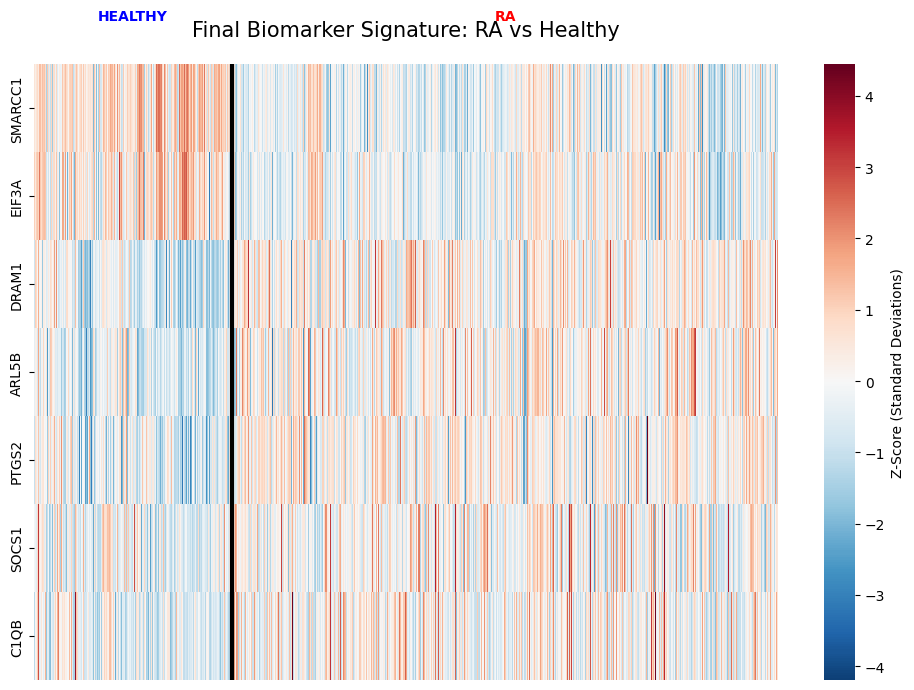

In [28]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 1. Select the "Cleanest" markers identified in your Volcano/RF
# These genes showed the highest significance and importance
clean_markers = ['SMARCC1', 'EIF3A', 'DRAM1', 'ARL5B', 'PTGS2', 'SOCS1', 'C1QB']

# 2. Extract and Scale
# Scaling is the key to removing "messiness"
plot_df = master_df_filtered[clean_markers + ['Label']].copy()
scaler = StandardScaler()
plot_df[clean_markers] = scaler.fit_transform(plot_df[clean_markers])

# 3. Sort by Disease to create distinct blocks
plot_df = plot_df.sort_values('Label')

# 4. Plot the Heatmap
plt.figure(figsize=(12, 8))
g = sns.heatmap(
    plot_df[clean_markers].T,
    cmap='RdBu_r',
    center=0,
    xticklabels=False,
    yticklabels=True,
    cbar_kws={'label': 'Z-Score (Standard Deviations)'}
)

# Add a color bar at the top to indicate where RA starts
# (Using a simple line to divide the groups visually)
ra_start_idx = len(plot_df[plot_df['Label'] == 'Healthy'])
plt.axvline(x=ra_start_idx, color='black', linewidth=3)
plt.text(ra_start_idx/2, -0.5, 'HEALTHY', ha='center', fontweight='bold', color='blue')
plt.text(ra_start_idx + (len(plot_df)-ra_start_idx)/2, -0.5, 'RA', ha='center', fontweight='bold', color='red')

plt.title('Final Biomarker Signature: RA vs Healthy', fontsize=15, pad=20)
plt.show()

##XGBoost



In [37]:
!pip install xgboost


In [38]:
import xgboost as xgb

Original training class distribution: {1: np.int64(516), 0: np.int64(188)}
Resampled training class distribution: {1: np.int64(516), 0: np.int64(516)}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:50:31] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:50:31] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:50:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost Parameters: {'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'random_state': 42, 'scale_pos_weight': 1, 'subsample': 0.8}

========================= TEST SET EVALUATION =========================
              precision    recall  f1-score   support

     Healthy       0.93      0.79      0.85        47
          RA       0.93      0.98      0.95       129

    accuracy                           0.93       176
   macro avg       0.93      0.88      0.90       176
weighted avg       0.93      0.93      0.92       176

Test ROC-AUC Score: 0.9677



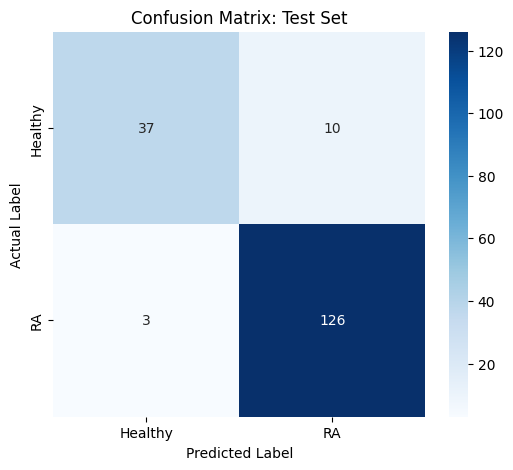

In [40]:
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import pandas as pd

def train_xgb_model(X_train, y_train):
    """
    Balances the dataset using SMOTE and uses Grid Search
    to find the best XGBoost parameters.
    """
    # 1. Handle Class Imbalance with SMOTE
    print(f"Original training class distribution: {dict(pd.Series(y_train).value_counts())}")
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    print(f"Resampled training class distribution: {dict(pd.Series(y_train_res).value_counts())}")

    # 2. Define XGBoost Parameter Grid
    # Note: scale_pos_weight is set to 1 because SMOTE already balanced the classes
    param_grid = {
        'n_estimators': [100,200],
        'max_depth': [3, 4, 5],            # Low depth is key even with 2000 genes
        'learning_rate': [0.01, 0.05, 0.1],      # Controls how fast the model learns
        'subsample': [0.8],                # Percentage of samples used per tree
        'colsample_bytree': [0.7, 0.8],    # Percentage of genes used per tree
        'scale_pos_weight': [1],
        'random_state': [42],
        'eval_metric': ['logloss']
    }

    # 3. Initialize the XGBoost Classifier
    xgb_base = xgb.XGBClassifier(
            use_label_encoder=False,
            tree_method='hist', # Faster algorithm
            device='cuda'        # Use NVIDIA GPU
        )

    # 4. Initialize and Run Grid Search
    grid_search = GridSearchCV(
        estimator=xgb_base,
        param_grid=param_grid,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1,
        verbose=2
    )

    grid_search.fit(X_train_res, y_train_res)

    print(f"Best XGBoost Parameters: {grid_search.best_params_}")

    # Return the best estimator
    return grid_search.best_estimator_

# --- Execution ---
from sklearn.metrics import roc_auc_score

def display_test_results(model, X_test, y_test, target_names):
    """
    Displays the Classification Report, ROC-AUC, and Confusion Matrix
    for the TEST set only.
    """
    # Get predictions and probabilities
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1] # Probability for the positive class

    # 1. Print Performance Metrics
    print(f"\n{'='*25} TEST SET EVALUATION {'='*25}")
    print(classification_report(y_test, y_pred, target_names=target_names))

    auc_val = roc_auc_score(y_test, y_probs)
    print(f"Test ROC-AUC Score: {auc_val:.4f}")
    print(f"{'='*67}\n")

    # 2. Plot the Confusion Matrix
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)

    plt.title('Confusion Matrix: Test Set')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# --- Execution ---

# 1. Train the XGBoost model
xgb_model = train_xgb_model(X_train, y_train)

# 2. Show only the Test Report and Confusion Matrix
display_test_results(xgb_model, X_test, y_test, le.classes_)

In [41]:
xgb_importances_hun = xgb_model.feature_importances_
xgb_importance_hundred = pd.DataFrame({'Gene': X.columns, 'Importance': xgb_importances})
xgb_importance_twohundred= xgb_importance_hundred.sort_values(by='Importance', ascending=False).head(2000)
print(xgb_importance_hundred)
xgb_importance_twohundred.to_csv('xgb_importance_twohundred.csv', index=False)


NameError: name 'xgb_importances' is not defined

In [42]:
# Get probabilities for your XGBoost Test Set
xgb_ra_probabilities = get_probability_predictions(xgb_model, X_test, X_test.index)

# Display the results
print("\n" + "="*20 + " XGBOOST RA RISK PROBABILITIES " + "="*20)
print(xgb_ra_probabilities.head(15)) # Showing top 15 highest risk samples


==================== XGBOOST RA RISK PROBABILITIES ====================
      Sample_ID  RA_Probability  Healthy_Probability Final_Diagnosis
130  GSM2449800        0.999720             0.000280              RA
43   GSM2449814        0.999670             0.000330              RA
45   GSM2449687        0.999635             0.000365              RA
26   GSM2449690        0.999629             0.000371              RA
8    GSM2449772        0.999598             0.000402              RA
75   GSM2449654        0.999582             0.000418              RA
83   GSM2449817        0.999192             0.000808              RA
78   GSM2449864        0.999086             0.000914              RA
38   GSM2981125        0.999057             0.000943              RA
175  GSM2449692        0.999023             0.000977              RA
16   GSM2449689        0.998867             0.001133              RA
53   GSM2449801        0.998863             0.001137              RA
61   GSM3449641        0.99883



> XGBoost visualization



/tmp/ipython-input-35000780.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Gene', data=xgb_importance_df, palette='magma')


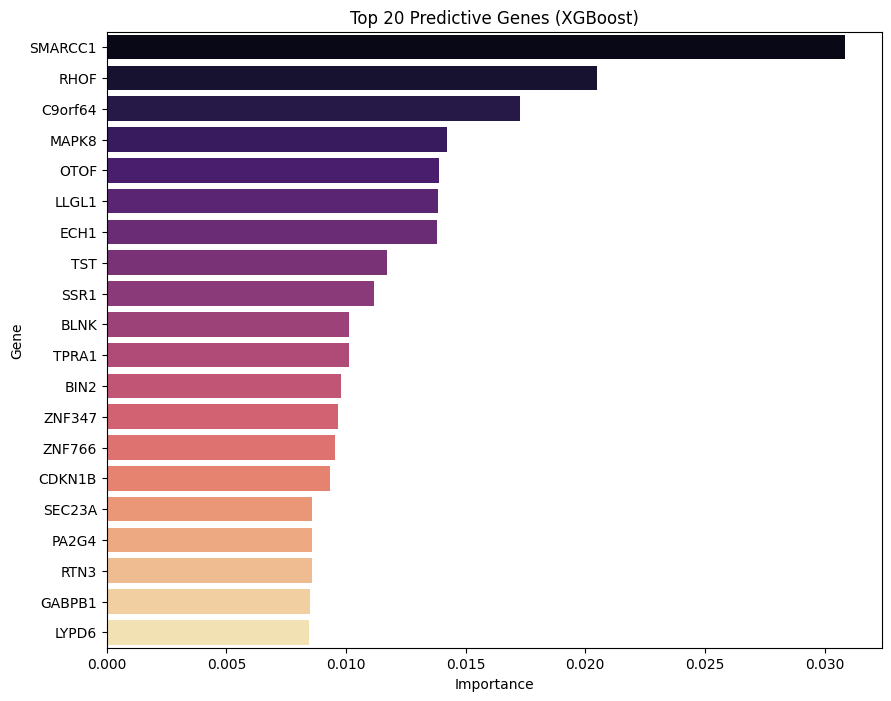

In [43]:
# Plot XGBoost Feature Importance (Top 20)
xgb_importances = xgb_model.feature_importances_
xgb_importance_df = pd.DataFrame({'Gene': X.columns, 'Importance': xgb_importances})
xgb_importance_df = xgb_importance_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Gene', data=xgb_importance_df, palette='magma')
plt.title('Top 20 Predictive Genes (XGBoost)')
plt.show()

## Support Vector Machine (SVM)

In [44]:
from sklearn.svm import SVC

def train_svm_model(X_train, y_train):
    print("Training SVM Model...")
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'probability': [True],
        'class_weight': ['balanced']
    }

    grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_train_res, y_train_res)

    print(f"Best SVM Params: {grid_search.best_params_}")
    return grid_search.best_estimator_

## Logistic Regression (with Lasso/L1)

In [45]:
from sklearn.linear_model import LogisticRegression

def train_logistic_regression(X_train, y_train):
    print("Training Logistic Regression...")
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    param_grid = {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1'], # Lasso for feature selection
        'solver': ['liblinear']
    }

    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_train_res, y_train_res)

    print(f"Best Logistic Reg Params: {grid_search.best_params_}")
    return grid_search.best_estimator_

## K-Nearest Neighbors (KNN)

In [46]:
from sklearn.neighbors import KNeighborsClassifier

def train_knn_model(X_train, y_train):
    print("Training KNN Model...")
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    param_grid = {
        'n_neighbors': [3, 5, 11, 21],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_train_res, y_train_res)

    print(f"Best KNN Params: {grid_search.best_params_}")
    return grid_search.best_estimator_

In [47]:
# Train all models
svm_model = train_svm_model(X_train, y_train)
lr_model  = train_logistic_regression(X_train, y_train)
knn_model = train_knn_model(X_train, y_train)

# Create a comparison table
models = {
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "SVM": svm_model,
    "Logistic Regression": lr_model,
    "KNN": knn_model
}

for name, model in models.items():
    test_acc = accuracy_score(y_test, model.predict(X_test))
    print(f"{name} Test Accuracy: {test_acc:.4f}")

Training SVM Model...
Best SVM Params: {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf', 'probability': True}
Training Logistic Regression...
Best Logistic Reg Params: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Training KNN Model...
Best KNN Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
XGBoost Test Accuracy: 0.9261
Random Forest Test Accuracy: 0.8636
SVM Test Accuracy: 0.9375
Logistic Regression Test Accuracy: 0.8693
KNN Test Accuracy: 0.6648


In [49]:
# import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def compare_models_leaderboard(models_dict, X_test, y_test):
    """
    Creates a comparison table for all trained models.
    """
    results = []

    for name, model in models_dict.items():
        # Get predictions
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, preds),
            'Precision (RA)': precision_score(y_test, preds),
            'Recall (Healthy)': recall_score(y_test, preds, pos_label=0), # Critical for RA
            'F1-Score (Macro)': f1_score(y_test, preds, average='macro'),
            'ROC-AUC': roc_auc_score(y_test, probs)
        })

    # Create DataFrame and sort by ROC-AUC (best overall performance)
    df_results = pd.DataFrame(results).sort_values(by='ROC-AUC', ascending=False)
    return df_results

# --- How to run ---
my_models = {
   "XGBoost": xgb_model,
   "Random Forest": rf_model,
   "SVM": svm_model,
   "Logistic Regression": lr_model,
   "KNN": knn_model
}
leaderboard = compare_models_leaderboard(my_models, X_test, y_test)
print(leaderboard)

                 Model  Accuracy  Precision (RA)  Recall (Healthy)  \
2                  SVM  0.937500        0.927536          0.787234   
0              XGBoost  0.926136        0.926471          0.787234   
1        Random Forest  0.863636        0.888889          0.680851   
3  Logistic Regression  0.869318        0.901515          0.723404   
4                  KNN  0.664773        0.972973          0.957447   

   F1-Score (Macro)   ROC-AUC  
2          0.914695  0.977734  
0          0.900759  0.967673  
1          0.818182  0.934686  
3          0.829565  0.891638  
4          0.656693  0.876134  


# SHAP (Global Explanation)

In [50]:
!pip install shap

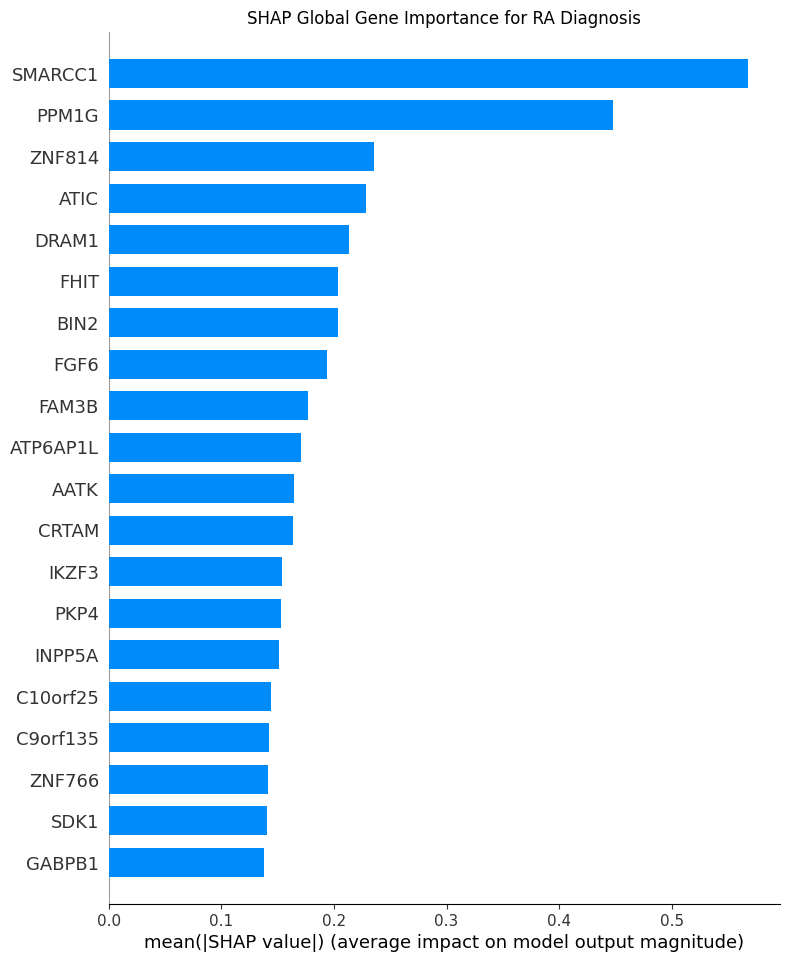

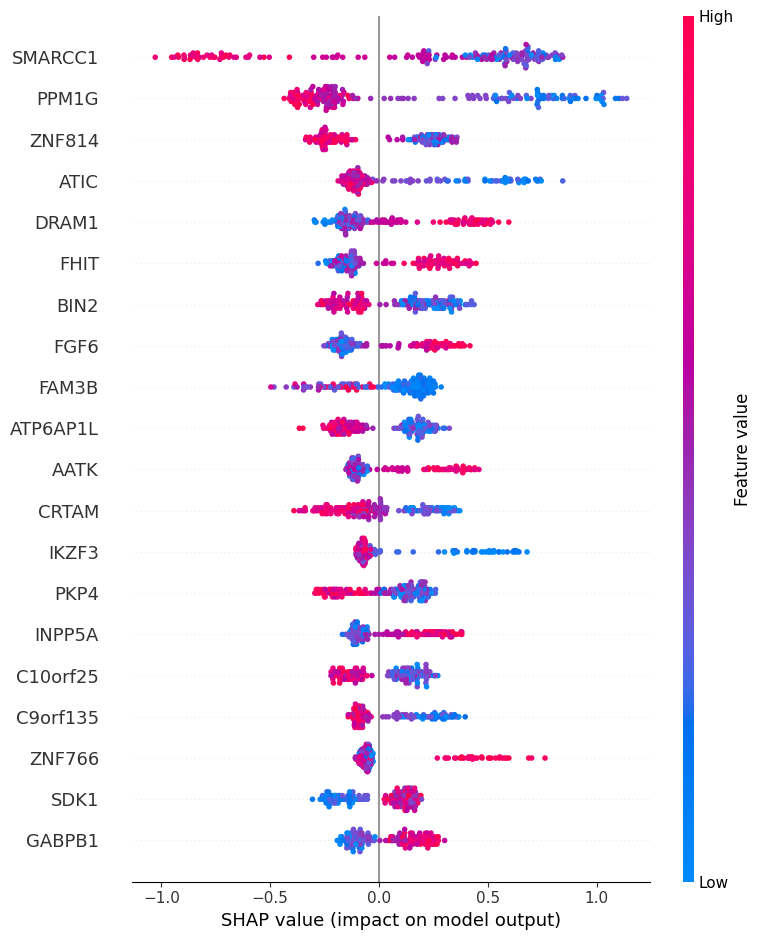

In [51]:
import shap

def explain_with_shap(model, X_train, X_test):
    # 1. Initialize Explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # 2. Summary Plot (The most important plot for a doctor)
    # It shows which genes push the risk up (red) or down (blue)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title("SHAP Global Gene Importance for RA Diagnosis")
    plt.show()

    # 3. Detailed Summary Plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test)
    plt.show()

# Run SHAP
explain_with_shap(xgb_model, X_train, X_test)

# LIME (Patient-Specific Explanation)

In [52]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=6480e215361a945861129f605699febfa2708a05a3f17ea3480ab8038afdda1a
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [53]:
import lime
import lime.lime_tabular

def explain_patient_with_lime(model, X_train, X_test, patient_index):
    # 1. Create LIME Explainer
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=np.array(X_train),
        feature_names=X_train.columns.tolist(),
        class_names=['Healthy', 'RA'],
        mode='classification'
    )

    # 2. Explain a specific patient
    exp = explainer.explain_instance(
        data_row=X_test.iloc[patient_index],
        predict_fn=model.predict_proba
    )

    # 3. Visualize for the Doctor
    print(f"Explanation for Patient ID: {X_test.index[patient_index]}")
    exp.show_in_notebook(show_table=True)

    # Save as HTML to send to your Frontend
    exp.save_to_file('patient_explanation.html')

# Explain the 1st patient in the test set
explain_patient_with_lime(xgb_model, X_train, X_test, 0)

/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Explanation for Patient ID: GSM2981263
